# Comprehensive Validation: Gas Crisis Scenario
Validation of synthetic data for gas price crisis scenario with 3 regimes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import json

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import re
from pathlib import Path
import os
import time
import hashlib

def file_info(p: Path):
    try:
        st = p.stat()
    except FileNotFoundError:
        return None
    return {
        "name": p.name,
        "path": str(p),
        "size": st.st_size,
        "mtime": st.st_mtime,
        "ctime": st.st_ctime,
        "atime": st.st_atime,
    }

def mtime_readable(ts):
    return time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(ts))

def choose_latest_phaseout(output_dir="../outputs", pattern="gas_crisis_scenario*.pkl"):
    output_dir = Path(output_dir)
    print("CWD:", Path.cwd())
    print("Resolved output_dir:", output_dir.resolve())
    print("Exists:", output_dir.exists(), "Is dir:", output_dir.is_dir())
    matches = list(output_dir.glob(pattern))
    print(f"Found {len(matches)} files matching pattern '{pattern}'")
    if not matches:
        return None

    infos = []
    for p in matches:
        info = file_info(p)
        infos.append((p, info))

    # Print diagnostics
    print("\nDiagnostics (name | size | mtime | ctime):")
    for p, info in sorted(infos, key=lambda x: x[0].name):
        print(
            f"{info['name']:40} {info['size']:10d}  mtime={mtime_readable(info['mtime'])}  "
            f"ctime={mtime_readable(info['ctime'])}"
        )

    # Heuristic 1: choose max by modification time
    latest_by_mtime = max(matches, key=lambda f: f.stat().st_mtime)

    # Heuristic 2: choose max by ctime (inode change / creation on some OS)
    latest_by_ctime = max(matches, key=lambda f: f.stat().st_ctime)

    # Heuristic 3: numeric suffix in the filename (if your naming is numeric)
    def extract_last_int(s):
        m = re.findall(r"(\d+)", s)
        return int(m[-1]) if m else -1

    latest_by_numeric = max(matches, key=lambda f: extract_last_int(f.stem))

    print("\nSelected by heuristics:")
    print("latest_by_mtime:", latest_by_mtime.name, mtime_readable(latest_by_mtime.stat().st_mtime))
    print("latest_by_ctime :", latest_by_ctime.name, mtime_readable(latest_by_ctime.stat().st_ctime))
    print("latest_by_numeric:", latest_by_numeric.name, "-> number:",
          extract_last_int(latest_by_numeric.stem))

    # As a safety: if mtimes disagree with numeric naming, show warning
    if latest_by_mtime != latest_by_numeric:
        print("\n⚠️ mtime and numeric order disagree. Think which is the ground truth for 'latest'.")
        # You can decide which to pick; here we return the file with the newest mtime (most common expectation)
    return latest_by_mtime

# usage
latest = choose_latest_phaseout("../outputs", "gas_crisis_scenario*.pkl")
if latest is None:
    print("❌ No gas crisis output files found!")
    print("Run: supplycurves run configs/1_gas_crisis.yaml")

else:
    print("\n-> Loading:", latest)
    df = pd.read_pickle(latest)
    print(f"✅ Loaded {len(df)} hours of data")

    # Ensure index is datetime-like (prefer explicit ts column)
    if not isinstance(df.index, pd.DatetimeIndex):
        for ts_col in ("ts", "time", "timestamp", "date", "datetime", "start_ts"):
            if ts_col in df.columns:
                df.index = pd.to_datetime(df[ts_col])
                break
            
    # now compute and print proper range/duration
    start = df.index.min()
    end = df.index.max()
    duration_days = (end - start).days
    print(f"Date range: {start} to {end}")
    print(f"Duration: {duration_days} days")
    print(f"\nColumns: {list(df.columns)}")

CWD: /Users/henrybaker/Repositories/synthetic-data-energy-markets/validation_notebooks
Resolved output_dir: /Users/henrybaker/Repositories/synthetic-data-energy-markets/outputs
Exists: True Is dir: True
Found 1 files matching pattern 'gas_crisis_scenario*.pkl'

Diagnostics (name | size | mtime | ctime):
gas_crisis_scenario_v1_2025_11_07_17_20.pkl    2525437  mtime=2025-11-07 17:20:44  ctime=2025-11-07 17:20:44

Selected by heuristics:
latest_by_mtime: gas_crisis_scenario_v1_2025_11_07_17_20.pkl 2025-11-07 17:20:44
latest_by_ctime : gas_crisis_scenario_v1_2025_11_07_17_20.pkl 2025-11-07 17:20:44
latest_by_numeric: gas_crisis_scenario_v1_2025_11_07_17_20.pkl -> number: 20

-> Loading: ../outputs/gas_crisis_scenario_v1_2025_11_07_17_20.pkl
✅ Loaded 8760 hours of data
Date range: 2024-01-01 00:00:00 to 2024-12-30 23:00:00
Duration: 364 days

Columns: ['index', 'timestamp', 'price', 'q_cleared', 'Q_wind', 'Q_solar', 'Q_nuclear', 'Q_coal', 'Q_gas', 'fuel.gas', 'fuel.coal', 'cap.nuclear', 'ca

# Overall check

@TODO: change tech colours to be more distinguished from eachother!

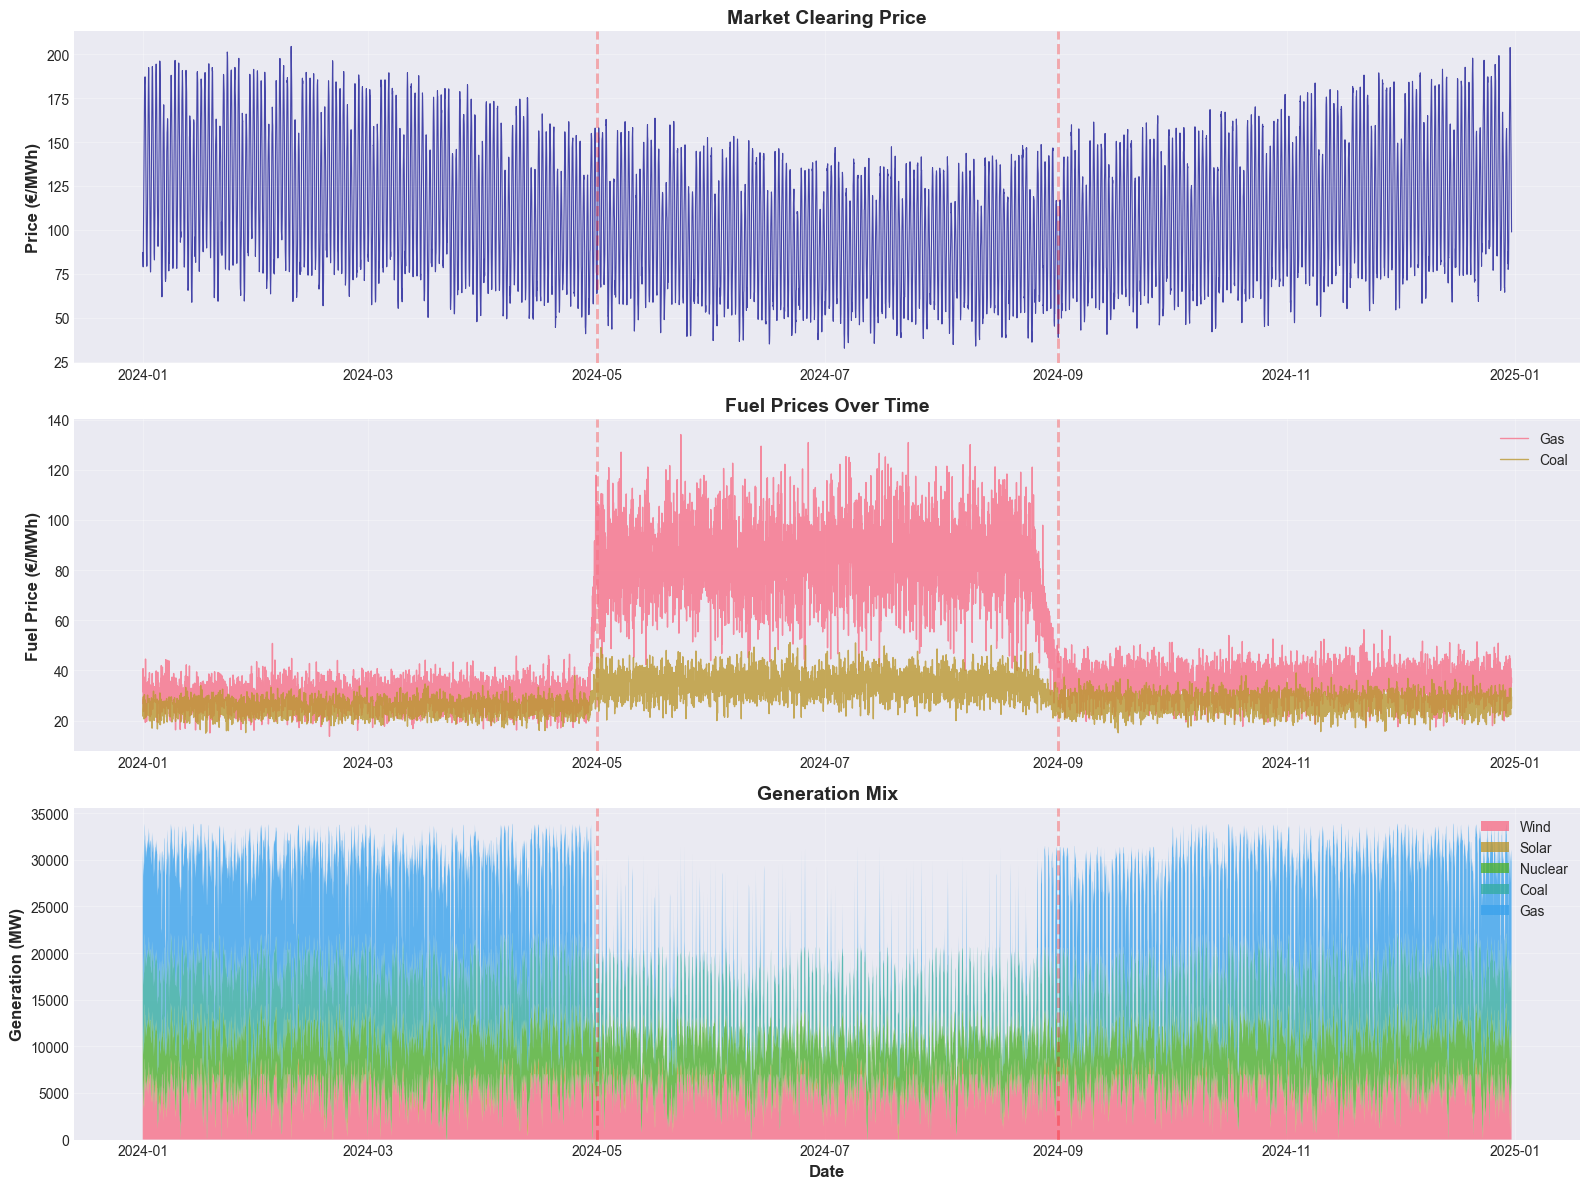

In [3]:
# Check if data loaded
if "df" in locals():
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))

    # Plot 1: Market Price
    axes[0].plot(df.index, df["price"], linewidth=0.8, alpha=0.7, color="darkblue")
    axes[0].set_ylabel("Price (€/MWh)", fontsize=12, fontweight="bold")
    axes[0].set_title("Market Clearing Price", fontsize=14, fontweight="bold")
    axes[0].grid(True, alpha=0.3)

    # Add regime boundaries if regime column exists
    if "fuel.gas_regime" in df.columns:
        regime_changes = df[
            df["fuel.gas_regime"] != df["fuel.gas_regime"].shift()
        ].index
        for change in regime_changes[1:]:
            for ax in axes:
                ax.axvline(change, color="red", linestyle="--", alpha=0.3, linewidth=2)

    # Plot 2: Fuel Prices
    if "fuel.gas" in df.columns and "fuel.coal" in df.columns:
        axes[1].plot(df.index, df["fuel.gas"], label="Gas", linewidth=1, alpha=0.8)
        axes[1].plot(df.index, df["fuel.coal"], label="Coal", linewidth=1, alpha=0.8)
        axes[1].set_ylabel("Fuel Price (€/MWh)", fontsize=12, fontweight="bold")
        axes[1].set_title("Fuel Prices Over Time", fontsize=14, fontweight="bold")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    # Plot 3: Generation Mix
    gen_cols = ["Q_wind", "Q_solar", "Q_nuclear", "Q_coal", "Q_gas"]
    if all(col in df.columns for col in gen_cols):
        axes[2].stackplot(
            df.index,
            df["Q_wind"],
            df["Q_solar"],
            df["Q_nuclear"],
            df["Q_coal"],
            df["Q_gas"],
            labels=["Wind", "Solar", "Nuclear", "Coal", "Gas"],
            alpha=0.8,
        )
        axes[2].set_ylabel("Generation (MW)", fontsize=12, fontweight="bold")
        axes[2].set_xlabel("Date", fontsize=12, fontweight="bold")
        axes[2].set_title("Generation Mix", fontsize=14, fontweight="bold")
        axes[2].legend(loc="upper right")
        axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 2. Regime Definition & Identification

In [4]:
# Check if regime column exists, if not create it
if 'regime' not in df.columns:
    regime_periods = [
        ('normal', '2024-01-01', '2024-05-01'),
        ('crisis', '2024-05-01', '2024-09-01'),
        ('post_crisis', '2024-09-01', '2025-01-01')
    ]
    
    df['regime'] = 'unknown'
    for regime_name, start, end in regime_periods:
        mask = (df.index >= start) & (df.index < end)
        df.loc[mask, 'regime'] = regime_name
else:
    print("Regime column already exists")

print("Regime distribution:")
print(df['regime'].value_counts())

Regime distribution:
regime
crisis         2952
normal         2904
post_crisis    2904
Name: count, dtype: int64


## 3. Distribution Analysis - All Random Variables

In [5]:
# Identify all variable columns
var_cols = [
    'fuel.gas', 'fuel.coal',
    'cap.nuclear', 'cap.coal', 'cap.gas', 'cap.wind', 'cap.solar',
    'avail.nuclear', 'avail.coal', 'avail.gas', 'avail.wind', 'avail.solar',
    'eta_lb.coal', 'eta_ub.coal', 'eta_lb.gas', 'eta_ub.gas',
    'bid.nuclear.min', 'bid.nuclear.max',
    'bid.wind.min', 'bid.wind.max',
    'bid.solar.min', 'bid.solar.max'
]

# Filter to existing columns
var_cols = [c for c in var_cols if c in df.columns]

print(f"Found {len(var_cols)} variable columns")

Found 22 variable columns


### 3.1 Overall Distributions (Histograms)

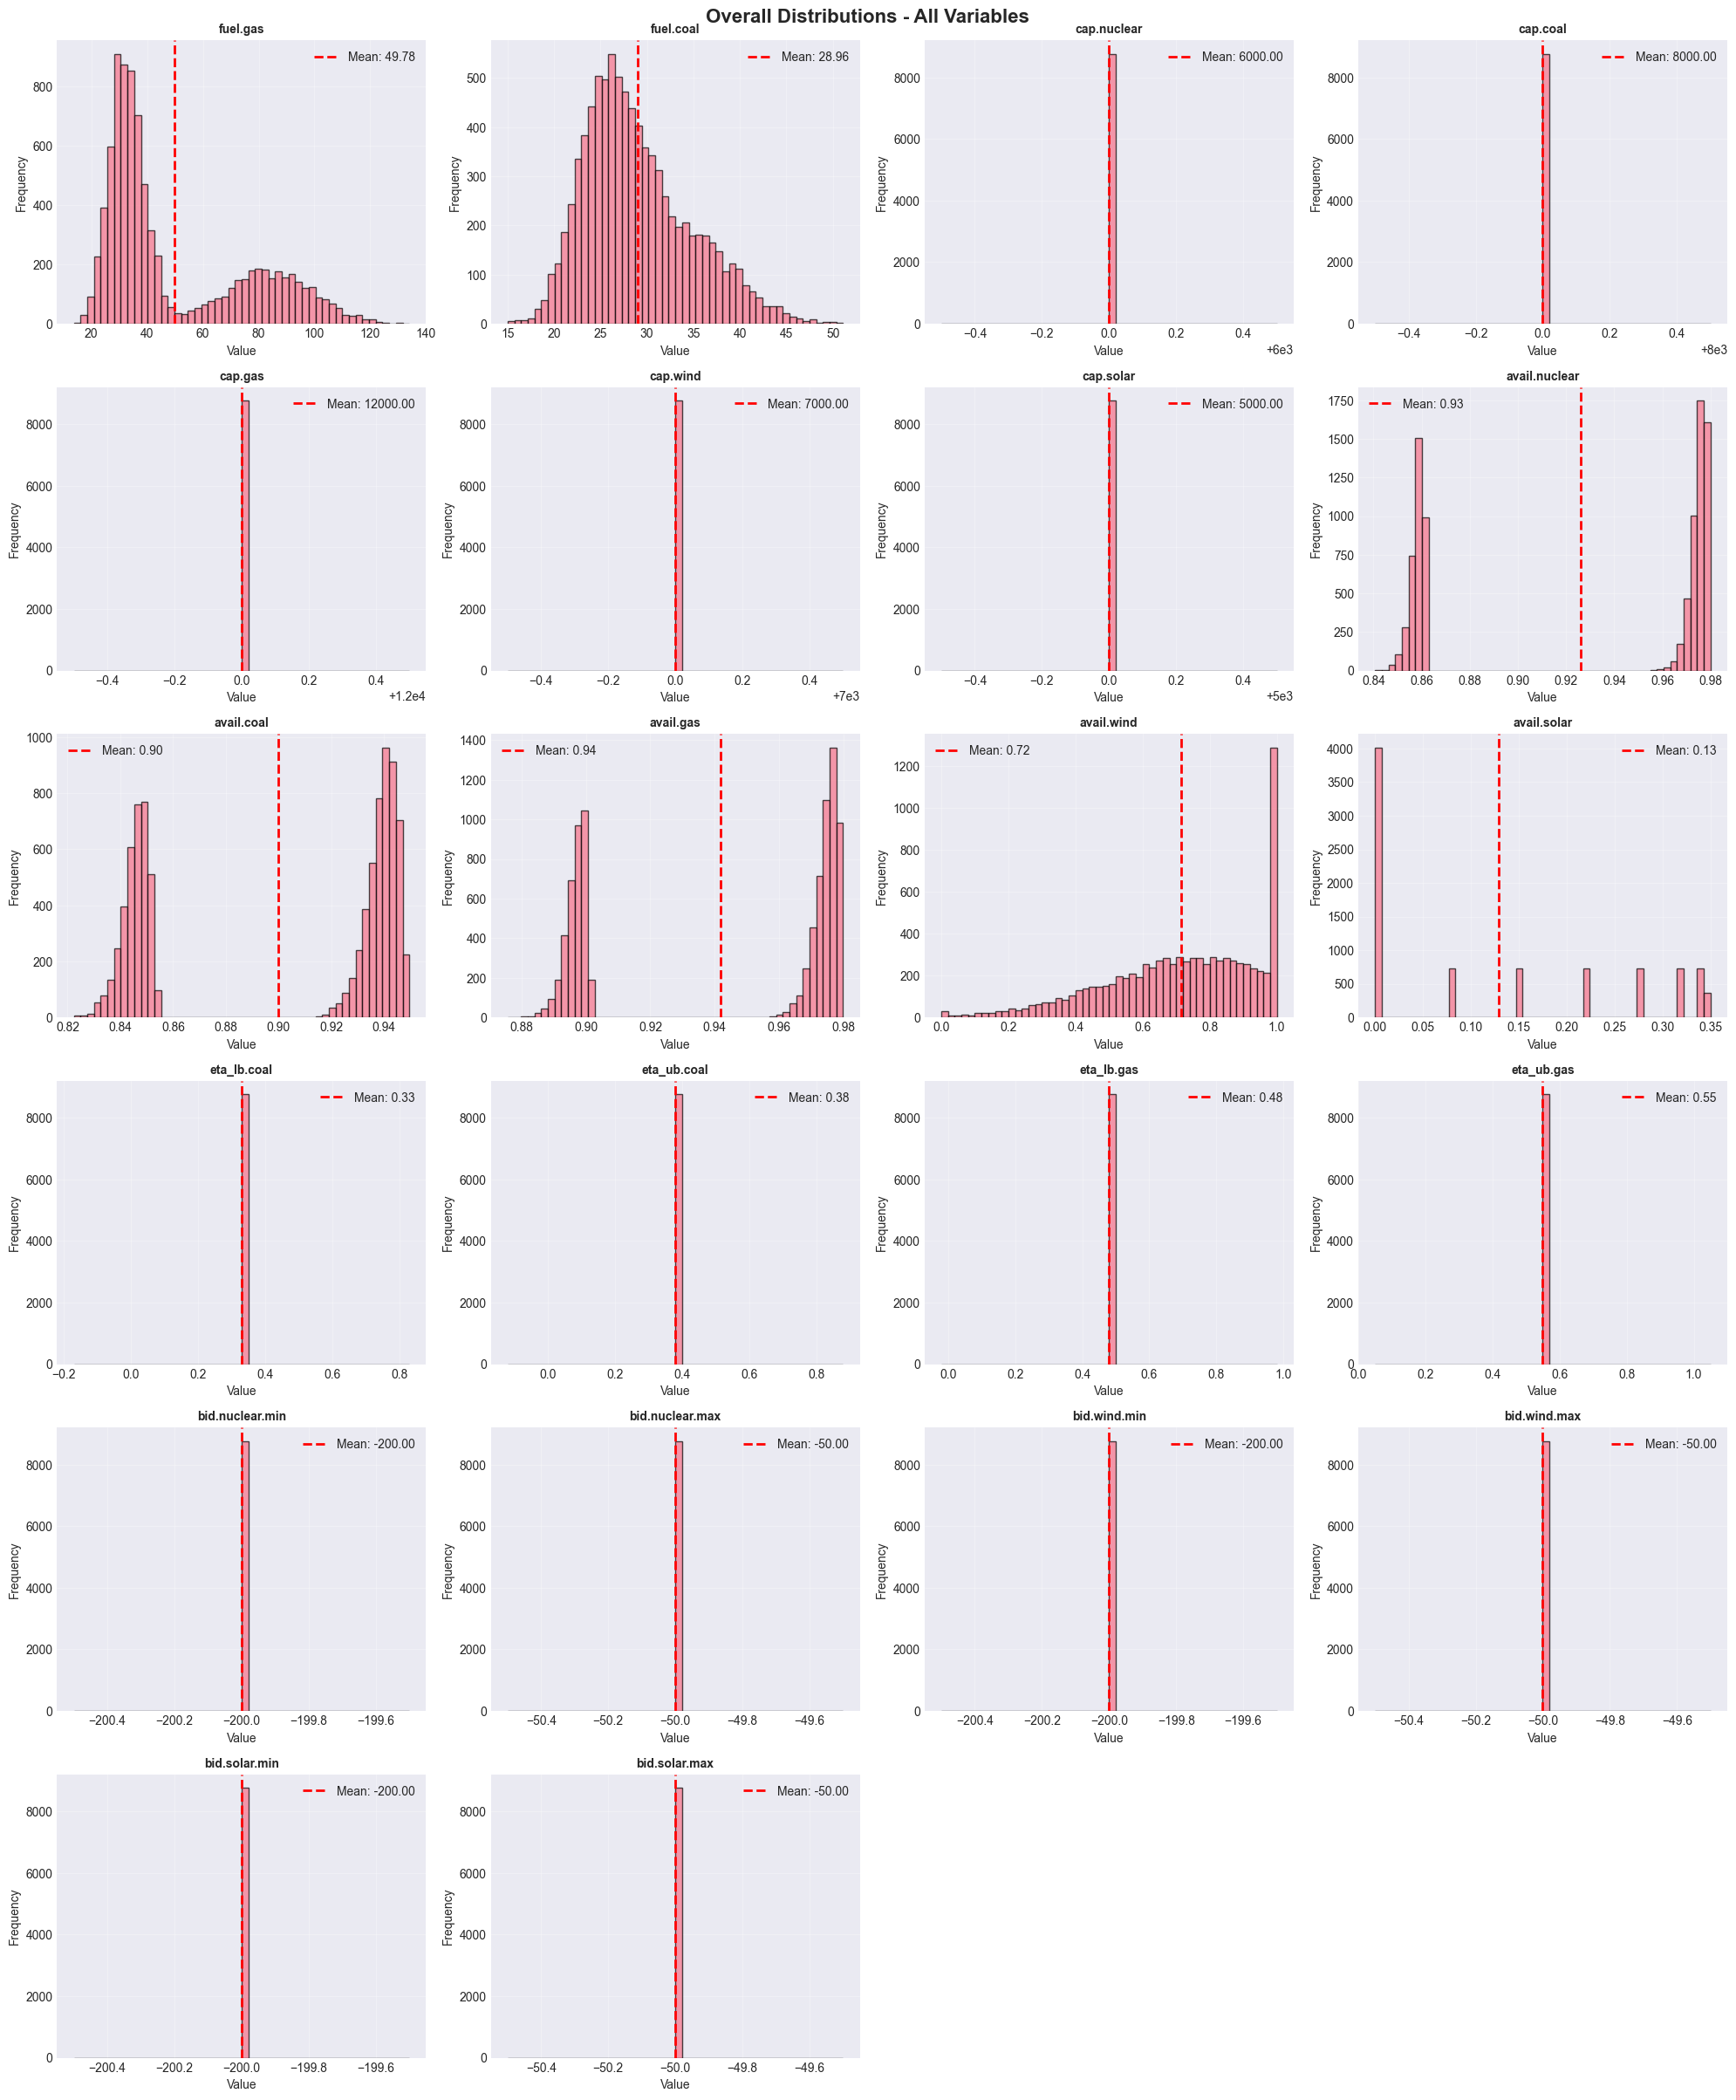

In [6]:
# Plot distributions for all variables
n_vars = len(var_cols)
n_cols = 4
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(var_cols):
    ax = axes[idx]
    
    # Plot histogram
    df[col].hist(bins=50, ax=ax, alpha=0.7, edgecolor='black')
    
    # Add stats
    mean_val = df[col].mean()
    std_val = df[col].std()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_vars, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Overall Distributions - All Variables', fontsize=16, fontweight='bold', y=1.001)
plt.show()

### 3.2 Time Series - All Variables

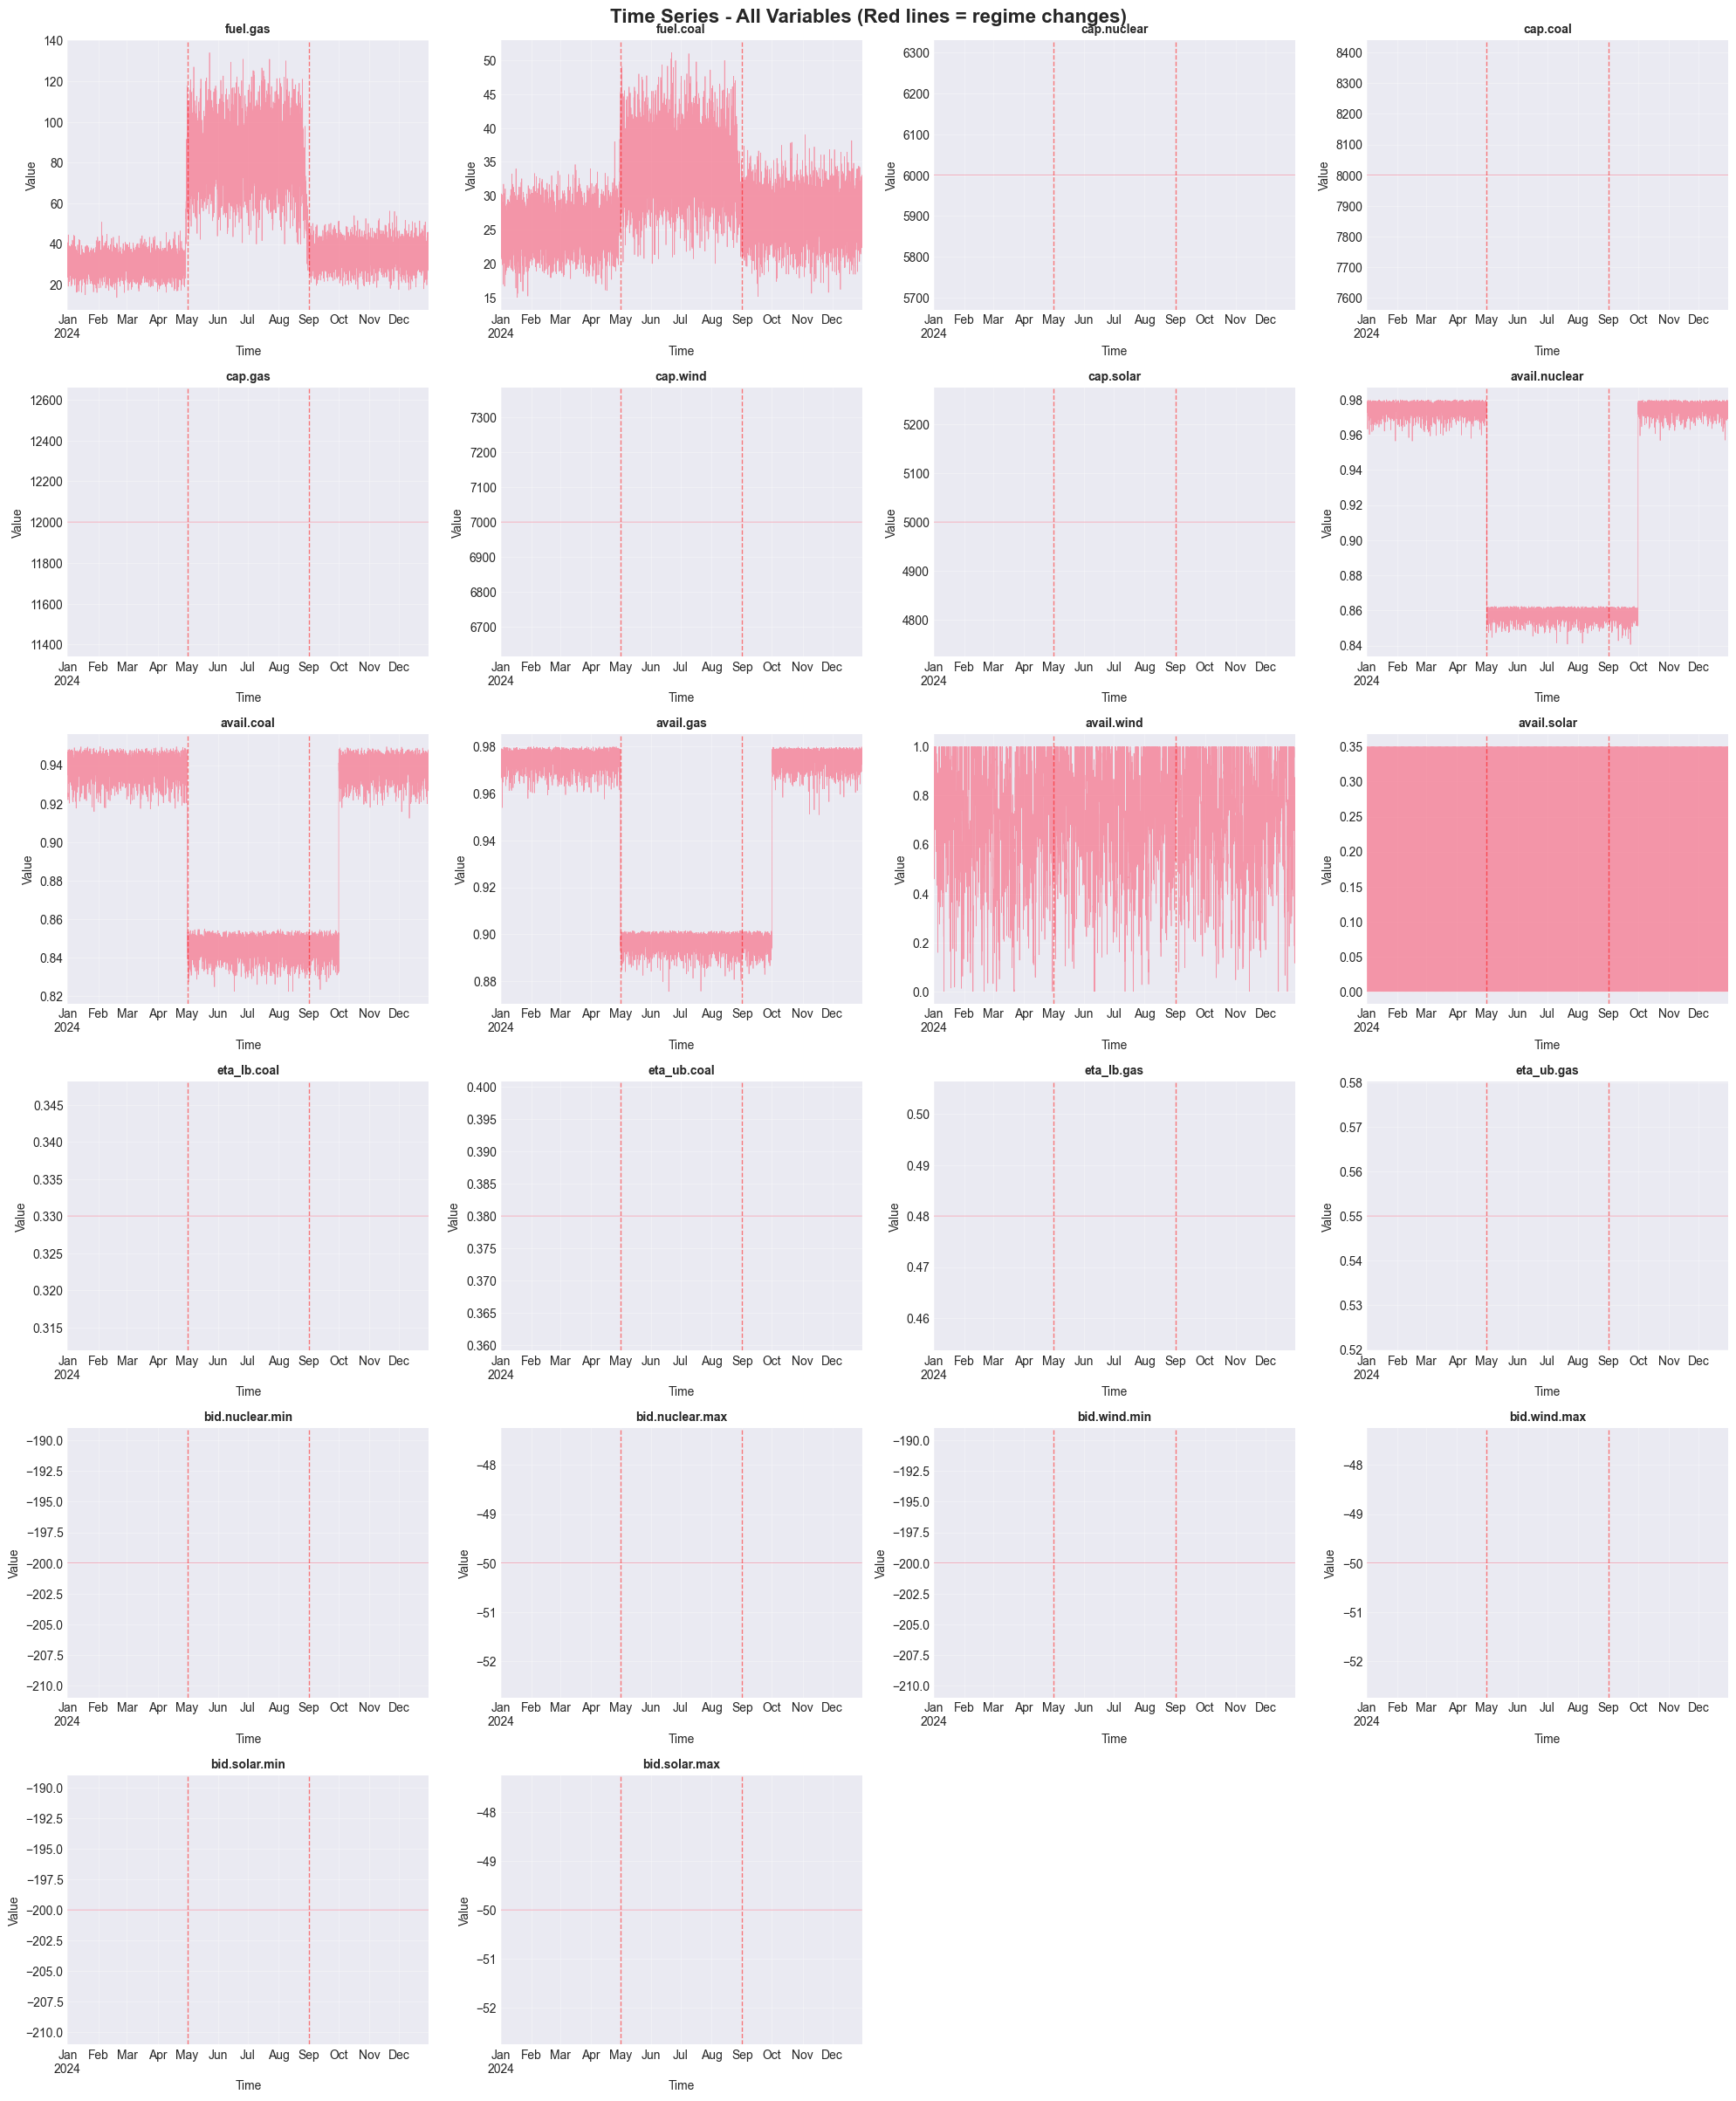

In [7]:
# Plot time series for all variables
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()

regime_periods = [
    ('normal', '2024-01-01', '2024-05-01'),
    ('crisis', '2024-05-01', '2024-09-01'),
    ('post_crisis', '2024-09-01', '2025-01-01')
]

for idx, col in enumerate(var_cols):
    ax = axes[idx]
    
    # Plot time series
    df[col].plot(ax=ax, linewidth=0.5, alpha=0.7)
    
    # Add regime boundaries
    for regime_name, start, end in regime_periods[1:]:
        ax.axvline(pd.Timestamp(start), color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_vars, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Time Series - All Variables (Red lines = regime changes)', fontsize=16, fontweight='bold', y=1.001)
plt.show()

### 3.3 Distributions by Regime (Fuel Prices)

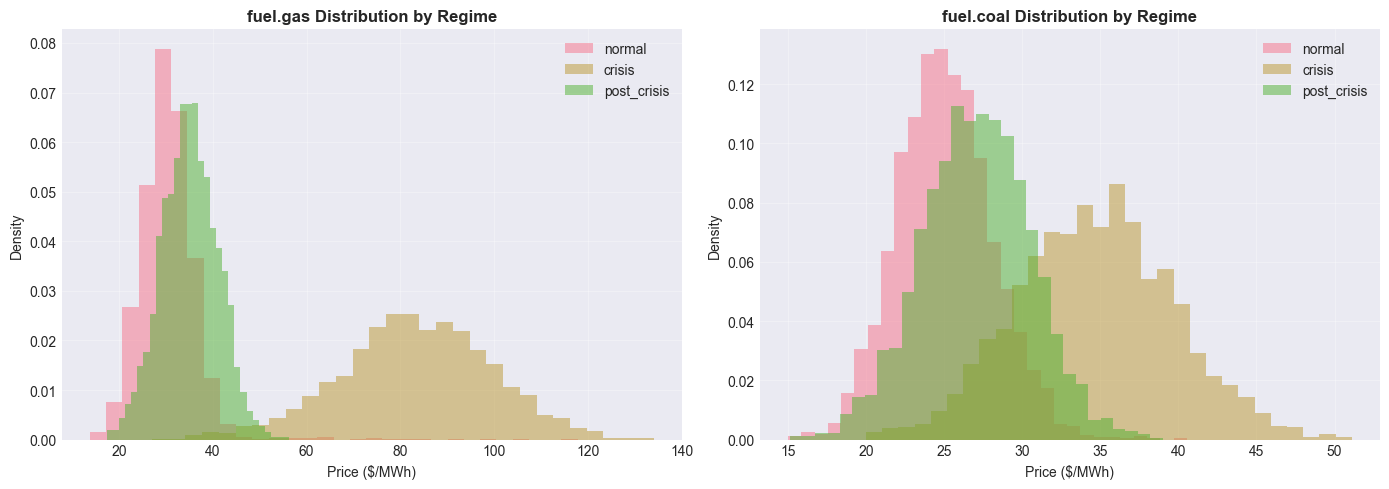

In [8]:
# Focus on fuel prices by regime
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, fuel in enumerate(['fuel.gas', 'fuel.coal']):
    ax = axes[idx]
    
    for regime in ['normal', 'crisis', 'post_crisis']:
        regime_data = df[df['regime'] == regime][fuel]
        regime_data.hist(bins=30, ax=ax, alpha=0.5, label=regime, density=True)
    
    ax.set_title(f'{fuel} Distribution by Regime', fontsize=12, fontweight='bold')
    ax.set_xlabel('Price ($/MWh)')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Demand Validation

### 4.1 Daily Seasonality

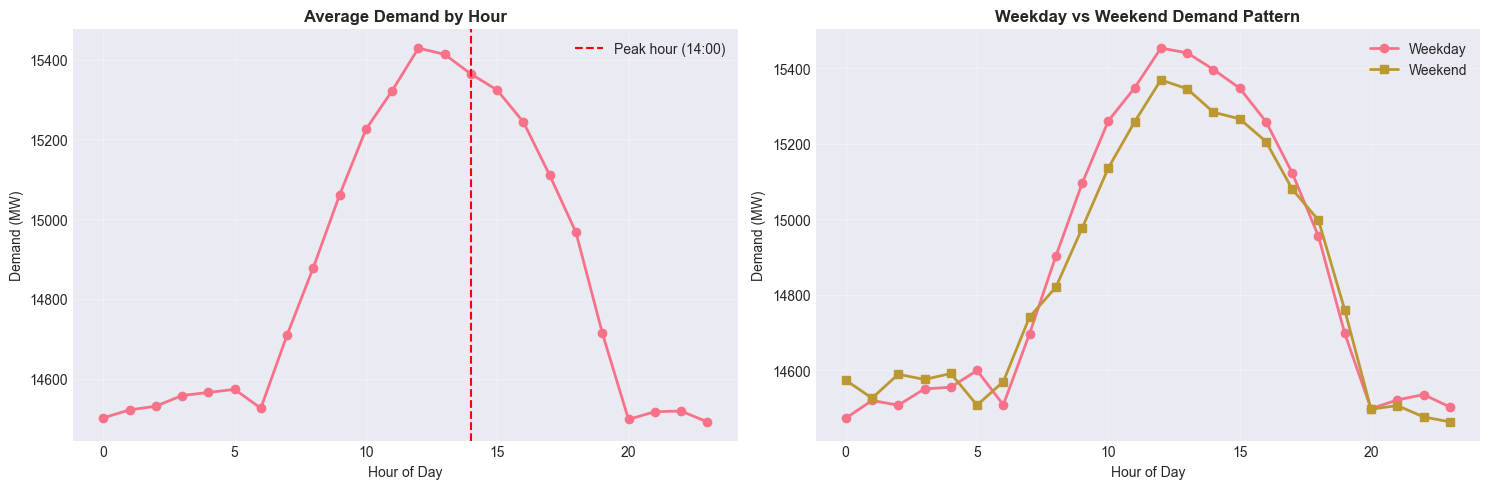


Weekday avg demand: 14864.43 MW
Weekend avg demand: 14838.15 MW
Weekend drop: 0.18%


In [9]:
# Extract demand quantity
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Average demand by hour
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Hourly pattern
hourly_avg = df.groupby('hour')['q_cleared'].mean()
axes[0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[0].axvline(14, color='red', linestyle='--', label='Peak hour (14:00)')
axes[0].set_title('Average Demand by Hour', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Demand (MW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Weekday vs Weekend
df['is_weekend'] = df['day_of_week'].isin([5, 6])
weekday_demand = df[~df['is_weekend']].groupby('hour')['q_cleared'].mean()
weekend_demand = df[df['is_weekend']].groupby('hour')['q_cleared'].mean()

axes[1].plot(weekday_demand.index, weekday_demand.values, marker='o', label='Weekday', linewidth=2)
axes[1].plot(weekend_demand.index, weekend_demand.values, marker='s', label='Weekend', linewidth=2)
axes[1].set_title('Weekday vs Weekend Demand Pattern', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Demand (MW)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nWeekday avg demand: {df[~df['is_weekend']]['q_cleared'].mean():.2f} MW")
print(f"Weekend avg demand: {df[df['is_weekend']]['q_cleared'].mean():.2f} MW")
print(f"Weekend drop: {((df[~df['is_weekend']]['q_cleared'].mean() - df[df['is_weekend']]['q_cleared'].mean()) / df[~df['is_weekend']]['q_cleared'].mean() * 100):.2f}%")

### 4.2 Annual Seasonality

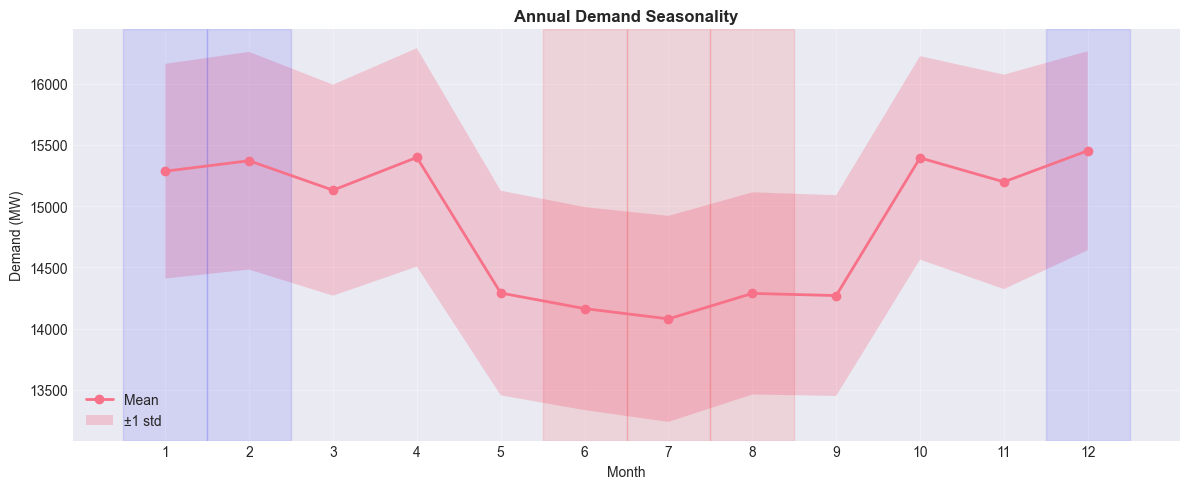


Winter avg demand: 15369.10 MW
Summer avg demand: 14176.86 MW
Seasonal variation: 8.41%


In [10]:
# Monthly demand pattern
fig, ax = plt.subplots(figsize=(12, 5))

monthly_avg = df.groupby('month')['q_cleared'].mean()
monthly_std = df.groupby('month')['q_cleared'].std()

ax.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, label='Mean')
ax.fill_between(monthly_avg.index, 
                monthly_avg.values - monthly_std.values,
                monthly_avg.values + monthly_std.values,
                alpha=0.3, label='±1 std')

# Mark summer months
for month in [6, 7, 8]:
    ax.axvspan(month-0.5, month+0.5, alpha=0.1, color='red')

# Mark winter months
for month in [1, 2, 12]:
    ax.axvspan(month-0.5, month+0.5, alpha=0.1, color='blue')

ax.set_title('Annual Demand Seasonality', fontsize=12, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Demand (MW)')
ax.set_xticks(range(1, 13))
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
winter_months = [1, 2, 12]
summer_months = [6, 7, 8]
winter_demand = df[df['month'].isin(winter_months)]['q_cleared'].mean()
summer_demand = df[df['month'].isin(summer_months)]['q_cleared'].mean()
print(f"\nWinter avg demand: {winter_demand:.2f} MW")
print(f"Summer avg demand: {summer_demand:.2f} MW")
print(f"Seasonal variation: {((winter_demand - summer_demand) / summer_demand * 100):.2f}%")

## 5. Planned Outages Validation


NUCLEAR:
  Non-outage mean: 0.9751
  Outage mean: 0.8581
  Reduction: 12.00%

COAL:
  Non-outage mean: 0.9392
  Outage mean: 0.8455
  Reduction: 9.97%

GAS:
  Non-outage mean: 0.9747
  Outage mean: 0.8967
  Reduction: 8.00%


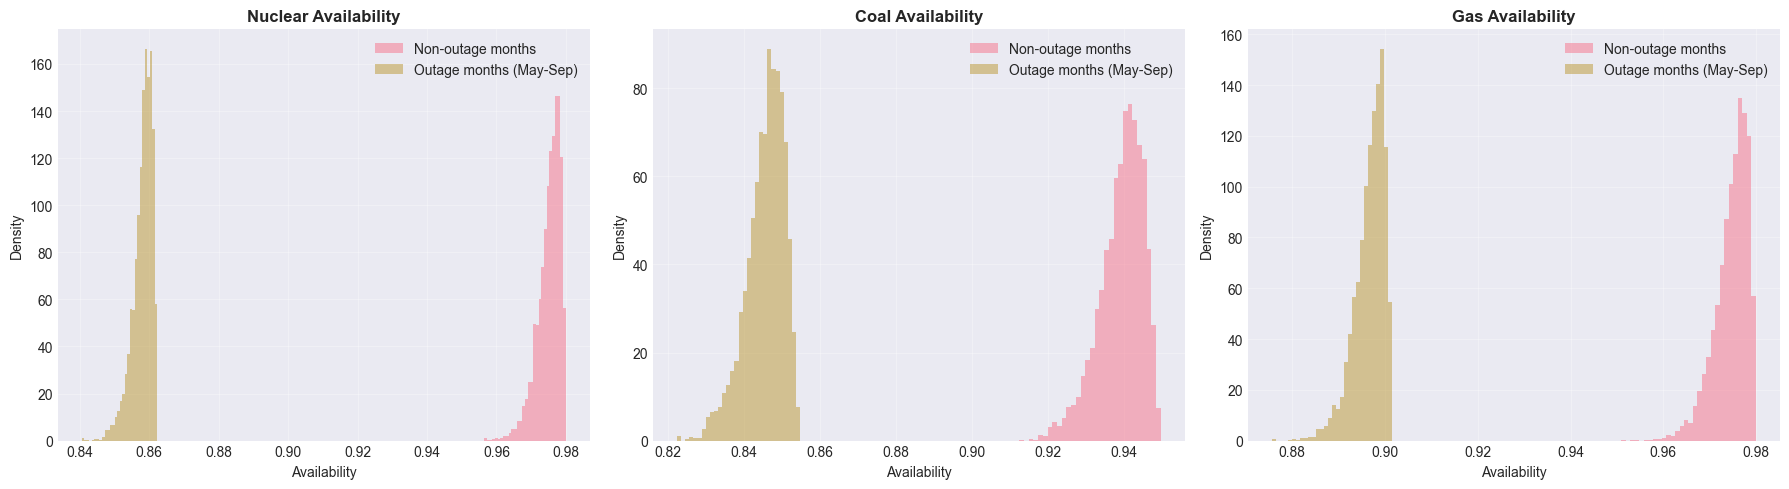

In [11]:
# Check availability reduction during summer months (May-Sep)
outage_months = [5, 6, 7, 8, 9]
non_outage_months = [m for m in range(1, 13) if m not in outage_months]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, tech in enumerate(['nuclear', 'coal', 'gas']):
    col = f'avail.{tech}'
    
    # Compare outage vs non-outage periods
    outage_avail = df[df['month'].isin(outage_months)][col]
    non_outage_avail = df[df['month'].isin(non_outage_months)][col]
    
    axes[idx].hist(non_outage_avail, bins=30, alpha=0.5, label='Non-outage months', density=True)
    axes[idx].hist(outage_avail, bins=30, alpha=0.5, label='Outage months (May-Sep)', density=True)
    
    axes[idx].set_title(f'{tech.capitalize()} Availability', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Availability')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Print stats
    print(f"\n{tech.upper()}:")
    print(f"  Non-outage mean: {non_outage_avail.mean():.4f}")
    print(f"  Outage mean: {outage_avail.mean():.4f}")
    print(f"  Reduction: {((non_outage_avail.mean() - outage_avail.mean()) / non_outage_avail.mean() * 100):.2f}%")

plt.tight_layout()
plt.show()

## 6. Renewable Availability Validation

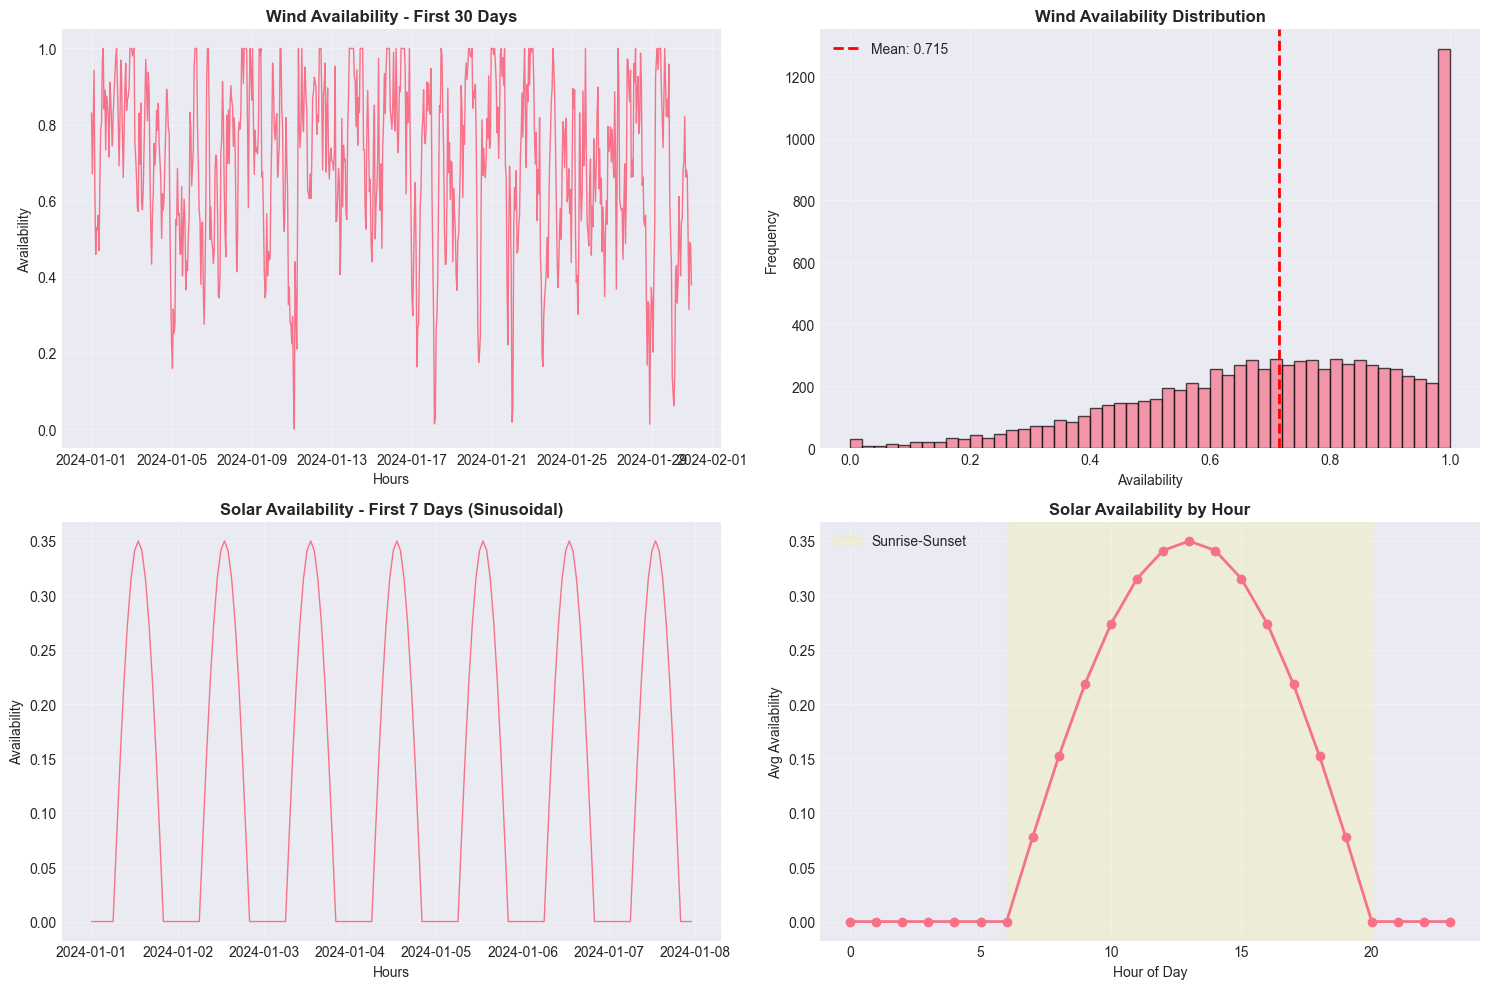


Wind stats: mean=0.715, std=0.223
Solar stats: mean=0.129, std=0.138


In [12]:
# Wind - should show AR(1) persistence
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Wind time series (first 30 days)
axes[0, 0].plot(df['avail.wind'].iloc[:30*24], linewidth=1)
axes[0, 0].set_title('Wind Availability - First 30 Days', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Hours')
axes[0, 0].set_ylabel('Availability')
axes[0, 0].grid(True, alpha=0.3)

# Wind distribution
axes[0, 1].hist(df['avail.wind'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['avail.wind'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["avail.wind"].mean():.3f}')
axes[0, 1].set_title('Wind Availability Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Availability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Solar time series (first 7 days)
axes[1, 0].plot(df['avail.solar'].iloc[:7*24], linewidth=1)
axes[1, 0].set_title('Solar Availability - First 7 Days (Sinusoidal)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Hours')
axes[1, 0].set_ylabel('Availability')
axes[1, 0].grid(True, alpha=0.3)

# Solar by hour
solar_hourly = df.groupby('hour')['avail.solar'].mean()
axes[1, 1].plot(solar_hourly.index, solar_hourly.values, marker='o', linewidth=2)
axes[1, 1].axvspan(6, 20, alpha=0.1, color='yellow', label='Sunrise-Sunset')
axes[1, 1].set_title('Solar Availability by Hour', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Avg Availability')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nWind stats: mean={df['avail.wind'].mean():.3f}, std={df['avail.wind'].std():.3f}")
print(f"Solar stats: mean={df['avail.solar'].mean():.3f}, std={df['avail.solar'].std():.3f}")

## 7. Market Outcomes - Triple Facet Analysis

### 7.1 Market Clearing Price by Regime

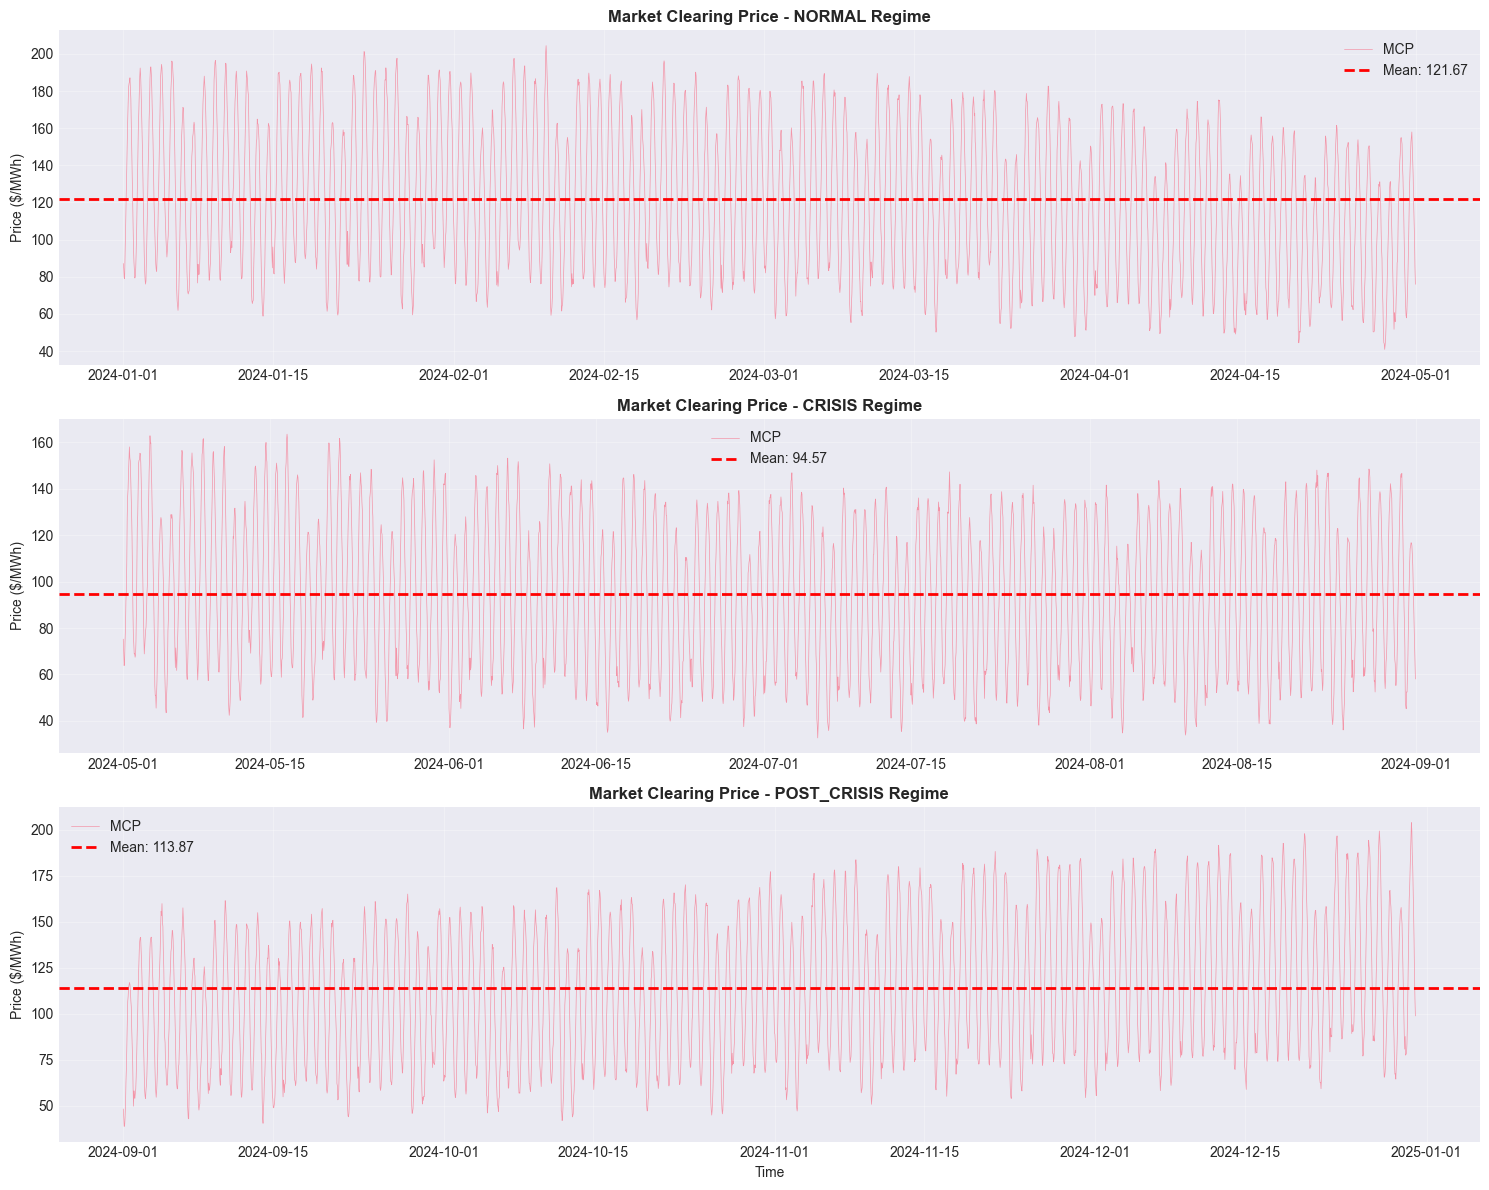

In [13]:
# Market clearing price analysis
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for idx, regime in enumerate(['normal', 'crisis', 'post_crisis']):
    regime_data = df[df['regime'] == regime]
    
    # Time series
    axes[idx].plot(regime_data.index, regime_data['price'], linewidth=0.5, alpha=0.7, label='MCP')
    axes[idx].axhline(regime_data['price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {regime_data["price"].mean():.2f}')
    
    axes[idx].set_title(f'Market Clearing Price - {regime.upper()} Regime', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Price ($/MWh)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

### 7.2 Fuel Prices by Regime

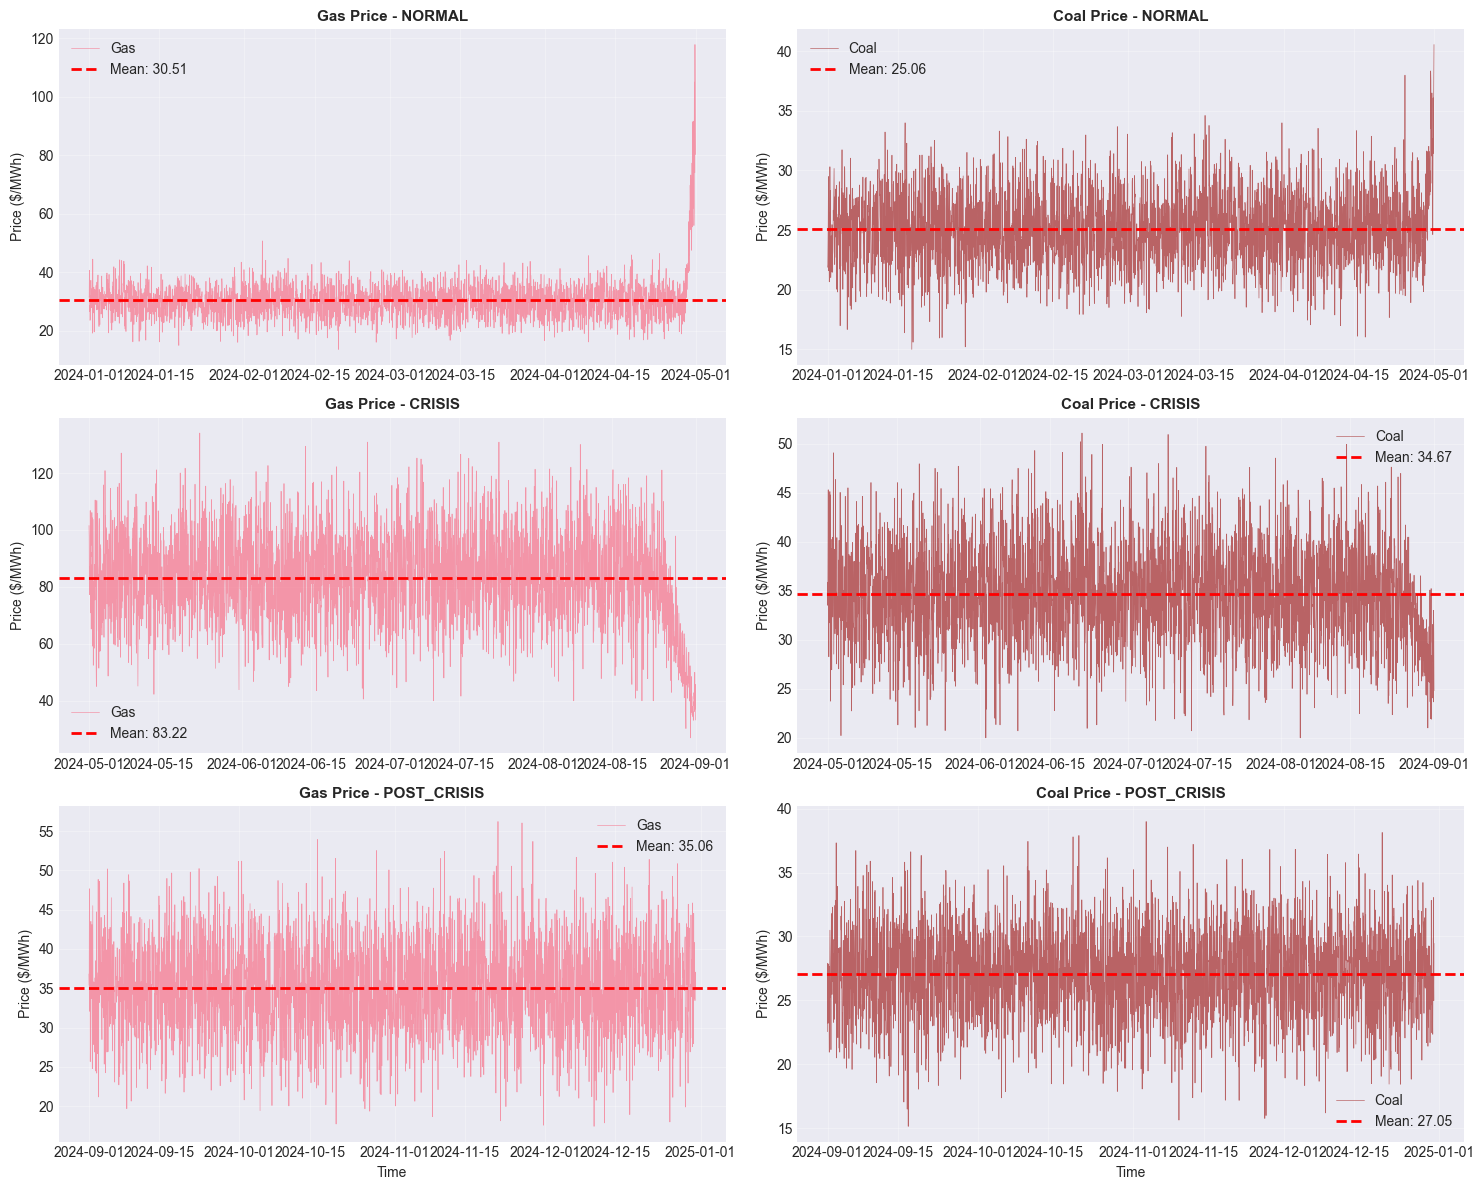

In [14]:
# Fuel prices by regime
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

for row_idx, regime in enumerate(['normal', 'crisis', 'post_crisis']):
    regime_data = df[df['regime'] == regime]
    
    # Gas prices
    axes[row_idx, 0].plot(regime_data.index, regime_data['fuel.gas'], linewidth=0.5, alpha=0.7, label='Gas')
    axes[row_idx, 0].axhline(regime_data['fuel.gas'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {regime_data["fuel.gas"].mean():.2f}')
    axes[row_idx, 0].set_title(f'Gas Price - {regime.upper()}', fontsize=11, fontweight='bold')
    axes[row_idx, 0].set_ylabel('Price ($/MWh)')
    axes[row_idx, 0].legend()
    axes[row_idx, 0].grid(True, alpha=0.3)
    
    # Coal prices
    axes[row_idx, 1].plot(regime_data.index, regime_data['fuel.coal'], linewidth=0.5, alpha=0.7, label='Coal', color='brown')
    axes[row_idx, 1].axhline(regime_data['fuel.coal'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {regime_data["fuel.coal"].mean():.2f}')
    axes[row_idx, 1].set_title(f'Coal Price - {regime.upper()}', fontsize=11, fontweight='bold')
    axes[row_idx, 1].set_ylabel('Price ($/MWh)')
    axes[row_idx, 1].legend()
    axes[row_idx, 1].grid(True, alpha=0.3)

axes[-1, 0].set_xlabel('Time')
axes[-1, 1].set_xlabel('Time')
plt.tight_layout()
plt.show()

### 7.3 Generation Mix by Regime

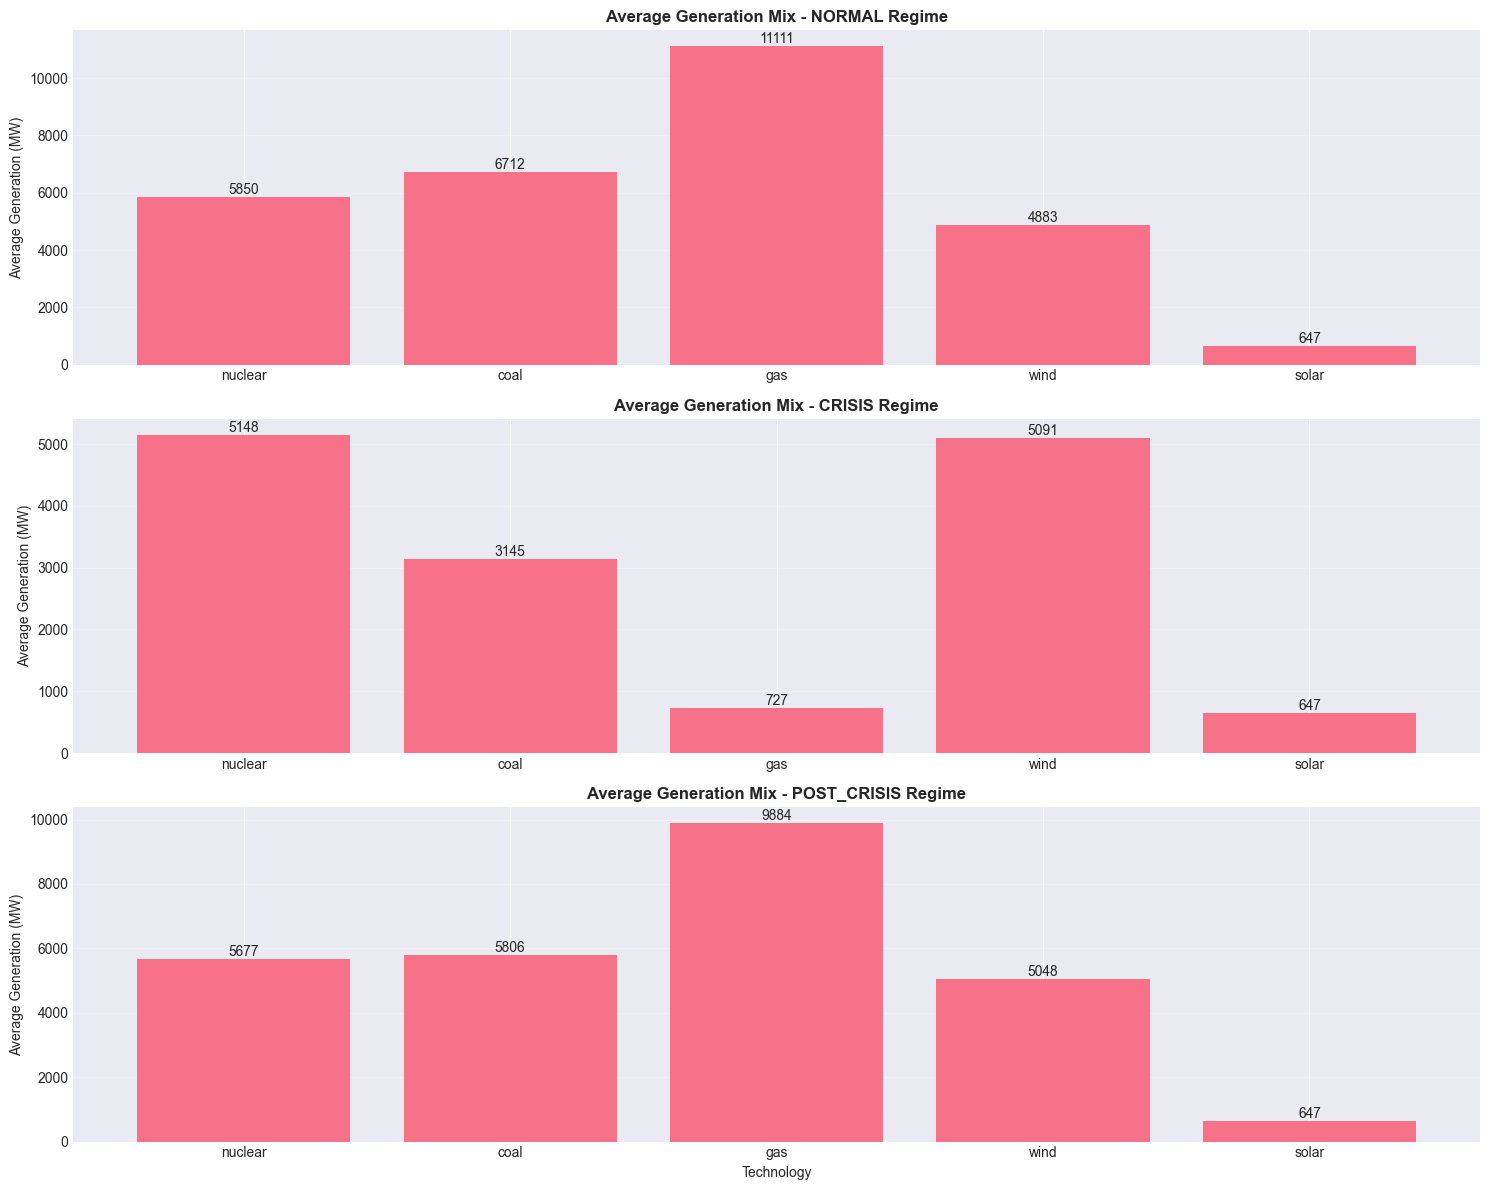

In [15]:
# Generation mix by regime
gen_cols = ['Q_nuclear', 'Q_coal', 'Q_gas', 'Q_wind', 'Q_solar']
techs = ['nuclear', 'coal', 'gas', 'wind', 'solar']

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for idx, regime in enumerate(['normal', 'crisis', 'post_crisis']):
    regime_data = df[df['regime'] == regime]
    
    # Calculate average generation by technology
    avg_gen = {tech: regime_data[col].mean() for tech, col in zip(techs, gen_cols)}
    
    # Bar chart
    axes[idx].bar(avg_gen.keys(), avg_gen.values())
    axes[idx].set_title(f'Average Generation Mix - {regime.upper()} Regime', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Average Generation (MW)')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for tech, val in avg_gen.items():
        axes[idx].text(tech, val, f'{val:.0f}', ha='center', va='bottom')

axes[-1].set_xlabel('Technology')
plt.tight_layout()
plt.show()

## 8. Technology Dispatch Over Time

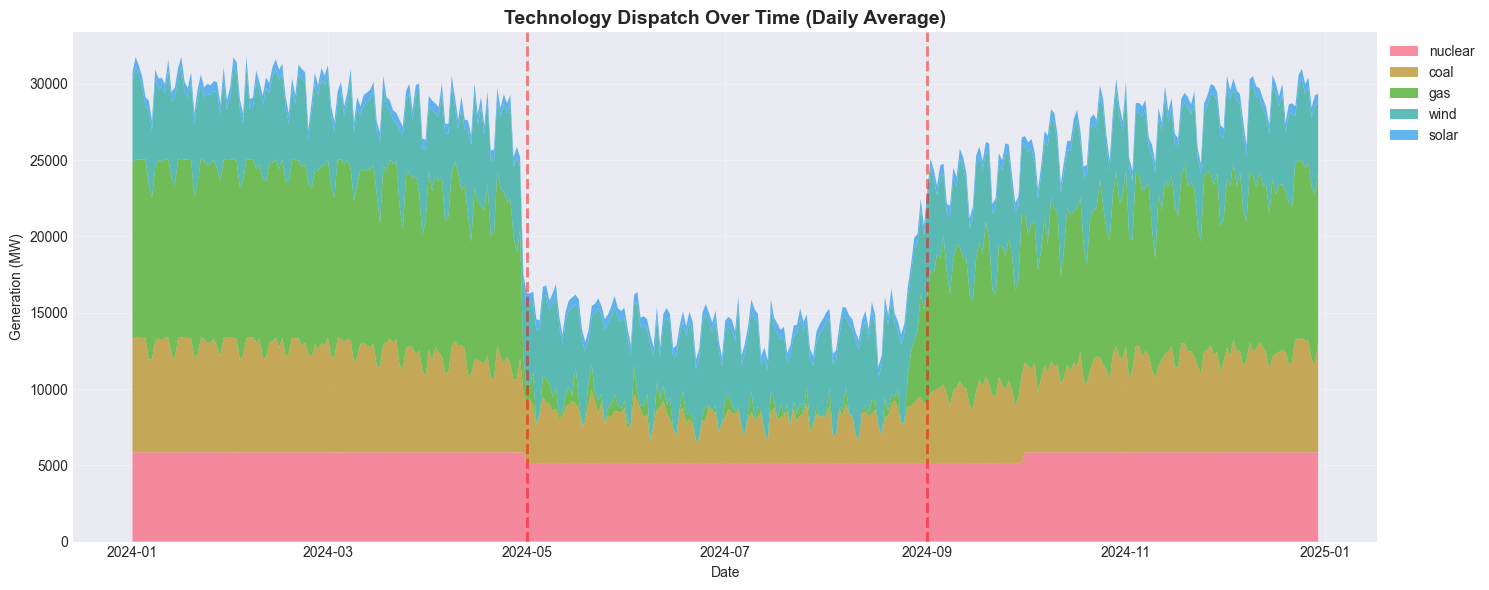

In [16]:
# Stack plot of generation over time
fig, ax = plt.subplots(figsize=(15, 6))

# Resample to daily for cleaner visualization
daily_gen = df[gen_cols].resample('D').mean()

ax.stackplot(daily_gen.index, 
             *[daily_gen[col] for col in gen_cols],
             labels=techs,
             alpha=0.8)

# Add regime boundaries
regime_periods = [
    ('normal', '2024-01-01', '2024-05-01'),
    ('crisis', '2024-05-01', '2024-09-01'),
    ('post_crisis', '2024-09-01', '2025-01-01')
]
for regime_name, start, end in regime_periods[1:]:
    ax.axvline(pd.Timestamp(start), color='red', linestyle='--', alpha=0.5, linewidth=2)

ax.set_title('Technology Dispatch Over Time (Daily Average)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Generation (MW)')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Generation Mix Over Time

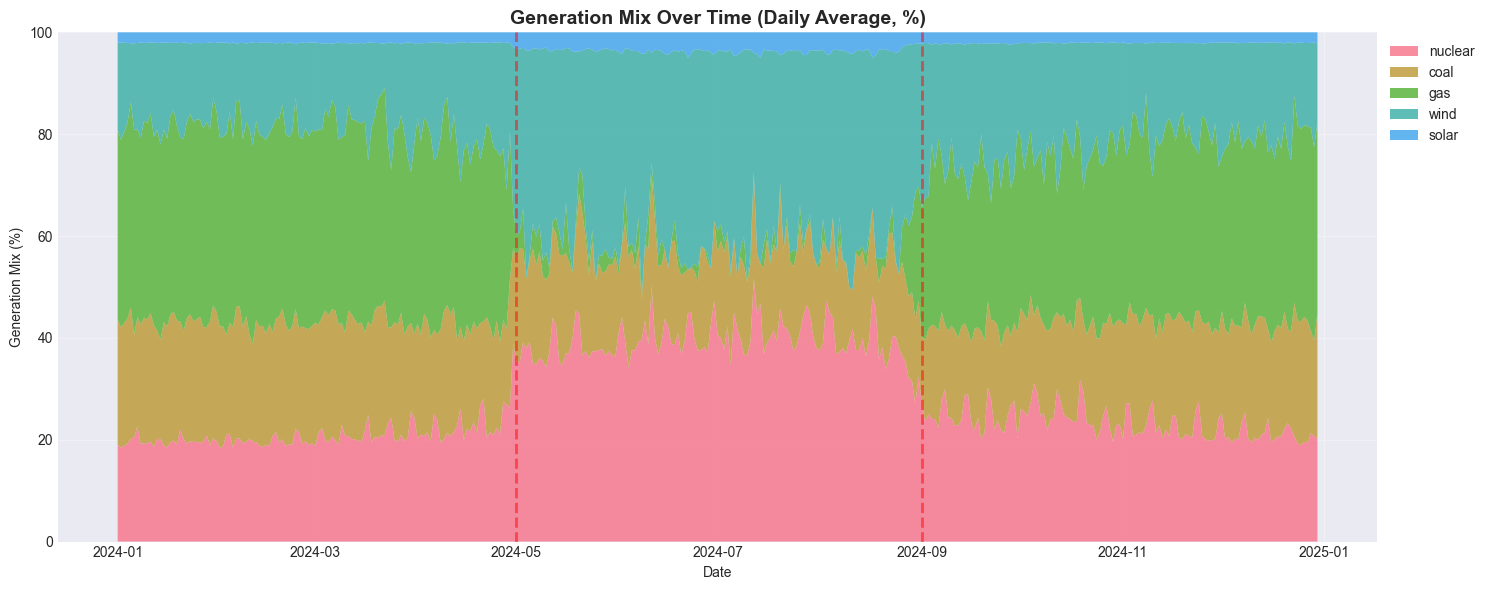

In [17]:
# Calculate percentage mix over time
df['total_gen'] = df[gen_cols].sum(axis=1)
mix_cols = []
for col, tech in zip(gen_cols, techs):
    mix_col = f'mix_{tech}'
    df[mix_col] = (df[col] / df['total_gen']) * 100
    mix_cols.append(mix_col)

# Resample to daily
daily_mix = df[mix_cols].resample('D').mean()

fig, ax = plt.subplots(figsize=(15, 6))

ax.stackplot(daily_mix.index,
             *[daily_mix[col] for col in mix_cols],
             labels=techs,
             alpha=0.8)

# Add regime boundaries
for regime_name, start, end in regime_periods[1:]:
    ax.axvline(pd.Timestamp(start), color='red', linestyle='--', alpha=0.5, linewidth=2)

ax.set_title('Generation Mix Over Time (Daily Average, %)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Generation Mix (%)')
ax.set_ylim(0, 100)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Supply Curve Analysis by Regime

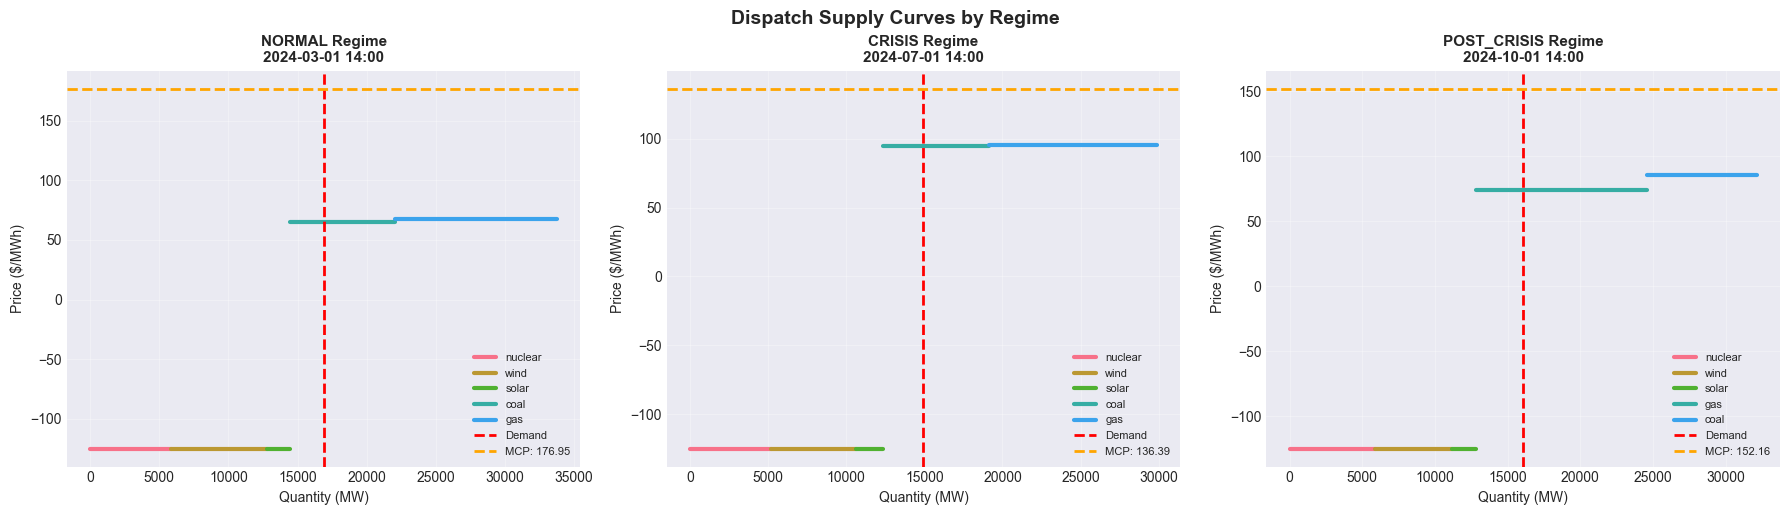

In [18]:
# Select representative timestamps from each regime
# Choose middle of each regime at peak hour (14:00)
timestamps = [
    ('normal', '2024-03-01 14:00'),
    ('crisis', '2024-07-01 14:00'),
    ('post_crisis', '2024-10-01 14:00')
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (regime, timestamp) in enumerate(timestamps):
    # Get the row for this timestamp
    ts_data = df.loc[timestamp]
    
    # Build supply curve for each technology
    supply_curves = []
    
    for tech, col in zip(techs, gen_cols):
        q_gen = ts_data[col]
        
        # Get marginal cost for thermal techs
        if tech == 'gas':
            mc = ts_data['fuel.gas'] / ((ts_data['eta_lb.gas'] + ts_data['eta_ub.gas']) / 2)
        elif tech == 'coal':
            mc = ts_data['fuel.coal'] / ((ts_data['eta_lb.coal'] + ts_data['eta_ub.coal']) / 2)
        elif tech in ['nuclear', 'wind', 'solar']:
            # Use bid price (average of min and max)
            mc = (ts_data[f'bid.{tech}.min'] + ts_data[f'bid.{tech}.max']) / 2
        else:
            mc = 0
        
        supply_curves.append({'tech': tech, 'quantity': q_gen, 'price': mc})
    
    # Sort by price
    supply_curves = sorted(supply_curves, key=lambda x: x['price'])
    
    # Create cumulative supply curve
    cumulative_q = 0
    for sc in supply_curves:
        q_start = cumulative_q
        q_end = cumulative_q + sc['quantity']
        axes[idx].plot([q_start, q_end], [sc['price'], sc['price']], 
                      linewidth=3, label=sc['tech'])
        axes[idx].plot([q_end, q_end], [sc['price'], sc['price']], 
                      linewidth=3, color='gray', alpha=0.3)
        cumulative_q = q_end
    
    # Add demand
    axes[idx].axvline(ts_data['q_cleared'], color='red', linestyle='--', linewidth=2, label='Demand')
    axes[idx].axhline(ts_data['price'], color='orange', linestyle='--', linewidth=2, label=f'MCP: {ts_data["price"]:.2f}')
    
    axes[idx].set_title(f'{regime.upper()} Regime\n{timestamp}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Quantity (MW)')
    axes[idx].set_ylabel('Price ($/MWh)')
    axes[idx].legend(loc='best', fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Dispatch Supply Curves by Regime', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## 11. Summary Statistics

In [19]:
# Summary statistics by regime
summary_vars = ['price', 'fuel.gas', 'fuel.coal', 'q_cleared'] + gen_cols

print("\n" + "="*80)
print("SUMMARY STATISTICS BY REGIME")
print("="*80)

for regime in ['normal', 'crisis', 'post_crisis']:
    print(f"\n{regime.upper()} REGIME:")
    print("-"*80)
    regime_data = df[df['regime'] == regime][summary_vars]
    print(regime_data.describe().T[['mean', 'std', 'min', 'max']].to_string())

# Overall statistics
print("\n" + "="*80)
print("OVERALL STATISTICS")
print("="*80)
print(df[summary_vars].describe().T[['mean', 'std', 'min', 'max']].to_string())


SUMMARY STATISTICS BY REGIME

NORMAL REGIME:
--------------------------------------------------------------------------------
                   mean          std           min           max
price        121.674146    38.920334     40.876339    204.430065
fuel.gas      30.508704     6.822741     13.713162    117.816309
fuel.coal     25.059480     3.077506     15.000000     40.547297
q_cleared  15294.473159   885.650941  12501.229428  16937.604929
Q_nuclear   5850.207084    20.571441   5738.363773   5879.791439
Q_coal      6712.404347  2163.379017      0.000000   7595.965449
Q_gas      11110.705805  2383.028347      0.000000  11759.296728
Q_wind      4882.547481  1633.237541      0.000000   7000.000000
Q_solar      647.153316   688.901428      0.000000   1750.000000

CRISIS REGIME:
--------------------------------------------------------------------------------
                   mean          std           min           max
price         94.573842    31.588967     32.638664    163.574

## 12. Validation Checks

In [20]:
print("\n" + "="*80)
print("VALIDATION CHECKS")
print("="*80)

# 1. Regime transition check
print("\n1. REGIME TRANSITIONS:")
gas_normal = df[df['regime'] == 'normal']['fuel.gas'].mean()
gas_crisis = df[df['regime'] == 'crisis']['fuel.gas'].mean()
gas_post = df[df['regime'] == 'post_crisis']['fuel.gas'].mean()
print(f"   Gas price: Normal={gas_normal:.2f}, Crisis={gas_crisis:.2f}, Post={gas_post:.2f}")
print(f"   Crisis spike: {((gas_crisis - gas_normal) / gas_normal * 100):.1f}%")
print(f"   ✓ Expected crisis spike confirmed" if gas_crisis > gas_normal * 2 else "   ✗ Crisis spike lower than expected")

# 2. Demand seasonality
print("\n2. DEMAND SEASONALITY:")
peak_hour_demand = df[df['hour'] == 14]['q_cleared'].mean()
offpeak_hour_demand = df[df['hour'] == 4]['q_cleared'].mean()
print(f"   Peak hour (14:00): {peak_hour_demand:.2f} MW")
print(f"   Off-peak hour (04:00): {offpeak_hour_demand:.2f} MW")
print(f"   Daily variation: {((peak_hour_demand - offpeak_hour_demand) / offpeak_hour_demand * 100):.1f}%")
print(f"   ✓ Daily seasonality confirmed" if peak_hour_demand > offpeak_hour_demand else "   ✗ No clear daily pattern")

# 3. Planned outages
print("\n3. PLANNED OUTAGES:")
for tech in ['nuclear', 'coal', 'gas']:
    non_outage = df[df['month'].isin([1,2,3,4,10,11,12])][f'avail.{tech}'].mean()
    outage = df[df['month'].isin([5,6,7,8,9])][f'avail.{tech}'].mean()
    reduction = ((non_outage - outage) / non_outage * 100)
    print(f"   {tech}: {reduction:.1f}% reduction during summer")
    print(f"   ✓ Outage effect confirmed" if reduction > 5 else "   ✗ Outage effect unclear")

# 4. Renewable patterns
print("\n4. RENEWABLE PATTERNS:")
solar_day = df[(df['hour'] >= 10) & (df['hour'] <= 16)]['avail.solar'].mean()
solar_night = df[(df['hour'] < 6) | (df['hour'] > 20)]['avail.solar'].mean()
print(f"   Solar daytime: {solar_day:.3f}")
print(f"   Solar nighttime: {solar_night:.3f}")
print(f"   ✓ Solar diurnal pattern confirmed" if solar_day > solar_night * 5 else "   ✗ Solar pattern unclear")

# 5. Supply-demand balance
print("\n5. SUPPLY-DEMAND BALANCE:")
df['total_supply'] = df[gen_cols].sum(axis=1)
balance_error = (df['total_supply'] - df['q_cleared']).abs().mean()
print(f"   Average absolute balance error: {balance_error:.2f} MW")
print(f"   Average relative error: {(balance_error / df['q_cleared'].mean() * 100):.3f}%")
print(f"   ✓ Supply-demand balance good" if balance_error < 1 else "   ✗ Balance error significant")

print("\n" + "="*80)


VALIDATION CHECKS

1. REGIME TRANSITIONS:
   Gas price: Normal=30.51, Crisis=83.22, Post=35.06
   Crisis spike: 172.8%
   ✓ Expected crisis spike confirmed

2. DEMAND SEASONALITY:
   Peak hour (14:00): 15364.10 MW
   Off-peak hour (04:00): 14565.59 MW
   Daily variation: 5.5%
   ✓ Daily seasonality confirmed

3. PLANNED OUTAGES:
   nuclear: 12.0% reduction during summer
   ✓ Outage effect confirmed
   coal: 10.0% reduction during summer
   ✓ Outage effect confirmed
   gas: 8.0% reduction during summer
   ✓ Outage effect confirmed

4. RENEWABLE PATTERNS:
   Solar daytime: 0.316
   Solar nighttime: 0.000
   ✓ Solar diurnal pattern confirmed

5. SUPPLY-DEMAND BALANCE:
   Average absolute balance error: 10275.55 MW
   Average relative error: 69.163%
   ✗ Balance error significant

